## Import libraries

In [1]:
from glob import glob
from matplotlib import pyplot as plt
from math import ceil, exp, pow, sqrt
#import networkx as nx
import numpy as np
import os
from PIL import Image
from random import randint, random
#from nxviz import CircosPlot
#from sklearn.manifold import TSNE

## Define functions

### Here, the convolution, normalize, and gaussian filter functions are defined. These are used in the definition of the smoothen() function, which is essential in our final segementation function.

In [2]:
def convolution(src, mask):
    output = np.zeros(shape=src.shape, dtype=float)
    height, width = src.shape
    length = len(mask)
    for y in range(height):
        for x in range(width):
            sum = float(mask[0] * src[y, x])
            for i in range(1, length):
                sum += mask[i] * (
                    #src[y, max(x - i, 0)] + src[y, min(x + i, width - 1)])
                    np.int16(src[y, max(x - i, 0)]) + np.int16(src[y, min(x + i, width - 1)]))
            output[y, x] = sum
    return output


def normalize(mask):
    sum = 2 * np.sum(np.absolute(mask)) + abs(mask[0])
    return np.divide(mask, sum)


def gaussian_filter(sigma):
    sigma = max(sigma, 0.01)
    length = int(ceil(sigma * 4.0)) + 1
    mask = np.zeros(shape=length, dtype=float)
    for i in range(length):
        mask[i] = exp(-0.5 * pow(i / sigma, i / sigma))
    return mask


def smoothen(src, sigma):
    mask = gaussian_filter(sigma)
    mask = normalize(mask)
    tmp = convolution(src, mask)
    dst = convolution(tmp, mask)
    return dst

### We further define the difference() and get_random_rgb_color() functions.
        - The difference() function is used to calculate the Euclidean distance between two pixels in the RGB space.
        - The get_random_rgb_color() function is used to generate a random RGB color as a 1D Numpy array.

In [3]:
def difference(red_band, green_band, blue_band, x1, y1, x2, y2):
    return sqrt(
        (red_band[y1, x1] - red_band[y2, x2]) ** 2 +\
            (green_band[y1, x1] - green_band[y2, x2]) ** 2 +\
                (blue_band[y1, x1] - blue_band[y2, x2]) ** 2
    )


def get_random_rgb_color():
    rgb = np.zeros(3, dtype=int)
    rgb[0] = randint(0, 255)
    rgb[1] = randint(0, 255)
    rgb[2] = randint(0, 255)
    return rgb


### Here, we define the Disjoint Set class. This method is used in the algorithm to find the connected components of the image graph.

In [4]:
class DisjointSet:
    
    def __init__(self, n_elements):
        self.num = n_elements
        self.elements = np.empty(
            shape=(n_elements, 3),
            dtype=int
        )
        for i in range(n_elements):
            self.elements[i, 0] = 0
            self.elements[i, 1] = 1
            self.elements[i, 2] = i

    def size(self, x):
        return self.elements[x, 1]

    def num_sets(self):
        return self.num

    def find(self, x):
        y = int(x)
        while y != self.elements[y, 2]:
            y = self.elements[y, 2]
        self.elements[x, 2] = y
        return y

    def join(self, x, y):
        if self.elements[x, 0] > self.elements[y, 0]:
            self.elements[y, 2] = x
            self.elements[x, 1] += self.elements[y, 1]
        else:
            self.elements[x, 2] = y
            self.elements[y, 1] += self.elements[x, 1]
            if self.elements[x, 0] == self.elements[y, 0]:
                self.elements[y, 0] += 1
        self.num -= 1


### The graph_segmentation() function is the algorithm that segments the image graph. It takes the number of vertices, edges, the edge list, and segment size as arguments. It returns the segmented graph as a disjoint set.

In [5]:
def graph_segmentation(num_vertices, num_edges, edges, c):
    edges[0 : num_edges, :] = edges[edges[0 : num_edges, 2].argsort()]
    u = DisjointSet(num_vertices)
    threshold = np.zeros(shape=num_vertices, dtype=float)
    for i in range(num_vertices):
        threshold[i] = c
    for i in range(num_edges):
        pedge = edges[i, :]
        a = u.find(pedge[0])
        b = u.find(pedge[1])
        if a != b:
            if (pedge[2] <= threshold[a]) and (pedge[2] <= threshold[b]):
                u.join(a, b)
                a = u.find(a)
                threshold[a] = pedge[2] + (c / u.size(a))
    return u

### The show_graph() function displays the graph as an adjacency matrix.
    - Multiple methods were tried, such as making a node-link diagram, a CircosPlot, and using graph embedding visualizations.
    - However, the adjacency matrix was the most efficient way to represent the graph, due to large sizes.
    - Even then, the program takes a long time to display the graph, and sometimes the system crashes due to memory overload.
    - Hence, the graph is not displayed in the final program.

In [6]:
'''def show_graph(edges):
    num_nodes = int(max(edges[:, :2].max(), edges[:, 1].max()) + 1)
    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
    for i in range(edges.shape[0]):
        node1 = int(edges[i, 0])
        node2 = int(edges[i, 1])
        adjacency_matrix[node1, node2] = 1
        adjacency_matrix[node2, node1] = 1
    print(adjacency_matrix)'''

'''def show_graph(edges):
    num_nodes = int(max(edges[:, :2].max(), edges[:, 1].max()) + 1)
    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
    for i in range(edges.shape[0]):
        node1 = int(edges[i, 0])
        node2 = int(edges[i, 1])
        adjacency_matrix[node1, node2] = 1
        adjacency_matrix[node2, node1] = 1
    
    G = nx.Graph(adjacency_matrix)
    nx.draw(G, with_labels=True)
    plt.show()'''


'''def show_graph(edges):
    num_nodes = int(max(edges[:, :2].max(), edges[:, 1].max()) + 1)
    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
    for i in range(edges.shape[0]):
        node1 = int(edges[i, 0])
        node2 = int(edges[i, 1])
        adjacency_matrix[node1, node2] = 1
        adjacency_matrix[node2, node1] = 1

    adjacency_list = np.where(adjacency_matrix == 1)
    adjacency_list = list(zip(adjacency_list[0], adjacency_list[1]))

    G = nx.Graph(adjacency_list)

    c = CircosPlot(G)
    c.draw()
    plt.show()'''

'''def show_graph(edges):
    num_nodes = int(max(edges[:, :2].max(), edges[:, 1].max()) + 1)
    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
    for i in range(edges.shape[0]):
        node1 = int(edges[i, 0])
        node2 = int(edges[i, 1])
        adjacency_matrix[node1, node2] = 1
        adjacency_matrix[node2, node1] = 1

    adjacency_list = np.where(adjacency_matrix == 1)
    adjacency_list = list(zip(adjacency_list[0], adjacency_list[1]))

    G = nx.Graph(adjacency_list)

    embedding = TSNE(n_components=2).fit_transform(adjacency_matrix)

    # Plot the graph
    plt.figure(figsize=(8, 8))
    plt.scatter(embedding[:, 0], embedding[:, 1], c='b', alpha=0.7)
    nx.draw_networkx(G, pos=embedding, with_labels=True, node_color='r', edge_color='gray', alpha=0.5)
    plt.title('t-SNE Graph Embedding')
    plt.show()'''


"def show_graph(edges):\n    num_nodes = int(max(edges[:, :2].max(), edges[:, 1].max()) + 1)\n    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)\n    for i in range(edges.shape[0]):\n        node1 = int(edges[i, 0])\n        node2 = int(edges[i, 1])\n        adjacency_matrix[node1, node2] = 1\n        adjacency_matrix[node2, node1] = 1\n\n    adjacency_list = np.where(adjacency_matrix == 1)\n    adjacency_list = list(zip(adjacency_list[0], adjacency_list[1]))\n\n    G = nx.Graph(adjacency_list)\n\n    embedding = TSNE(n_components=2).fit_transform(adjacency_matrix)\n\n    # Plot the graph\n    plt.figure(figsize=(8, 8))\n    plt.scatter(embedding[:, 0], embedding[:, 1], c='b', alpha=0.7)\n    nx.draw_networkx(G, pos=embedding, with_labels=True, node_color='r', edge_color='gray', alpha=0.5)\n    plt.title('t-SNE Graph Embedding')\n    plt.show()"

### Segment() is the main segmentation function. 
    The function takes 4 arguments:
        1. image: The image to be segmented.
        2. sigma: The standard deviation of the Gaussian filter.
        3. k: The constant used in the calculation of the threshold.
        4. min_size: The minimum size of segments allowed.

    How it works:
        1. Extract the height, width, and number of color bands of the image.
        2. Apply a Gaussian smoothing operation to the image.
        3. Build a graph of the image, where every pixel is a vertex, and each edge connects the pixel to its neighbors. Edge weights are the color difference between the pixels.
        4. Segment the graph using the graph_segmentation() function.
        5. Iterate over each edge again, and merge the vertices of the edge if the edge weight is less than the threshold defined by min_size.
        6. Return segmented image, where segments are assigned random colors, and pixels are colored according to the segment they belong to.

In [7]:
def segment(in_image, sigma, k, min_size):
    height, width, band = in_image.shape
    smooth_red_band = smoothen(in_image[:, :, 0], sigma)
    smooth_green_band = smoothen(in_image[:, :, 1], sigma)
    smooth_blue_band = smoothen(in_image[:, :, 2], sigma)
    # build graph
    edges_size = width * height * 4
    edges = np.zeros(shape=(edges_size, 3), dtype=object)
    num = 0
    for y in range(height):
        for x in range(width):
            if x < width - 1:
                edges[num, 0] = int(y * width + x)
                edges[num, 1] = int(y * width + (x + 1))
                edges[num, 2] = difference(
                    smooth_red_band, smooth_green_band,
                    smooth_blue_band, x, y, x + 1, y
                )
                num += 1
            if y < height - 1:
                edges[num, 0] = int(y * width + x)
                edges[num, 1] = int((y + 1) * width + x)
                edges[num, 2] = difference(
                    smooth_red_band, smooth_green_band,
                    smooth_blue_band, x, y, x, y + 1
                )
                num += 1
            if (x < width - 1) and (y < height - 2):
                edges[num, 0] = int(y * width + x)
                edges[num, 1] = int((y + 1) * width + (x + 1))
                edges[num, 2] = difference(
                    smooth_red_band, smooth_green_band,
                    smooth_blue_band, x, y, x + 1, y + 1
                )
                num += 1
            if (x < width - 1) and (y > 0):
                edges[num, 0] = int(y * width + x)
                edges[num, 1] = int((y - 1) * width + (x + 1))
                edges[num, 2] = difference(
                    smooth_red_band, smooth_green_band,
                    smooth_blue_band, x, y, x + 1, y - 1
                )
                num += 1

    u = graph_segmentation(width * height, num, edges, k)
    for i in range(num):
        a = u.find(edges[i, 0])
        b = u.find(edges[i, 1])
        if (a != b) and ((u.size(a) < min_size) or (u.size(b) < min_size)):
            u.join(a, b)
    num_cc = u.num_sets()

    output = np.zeros(shape=(height, width, 3))
    #show_graph(edges) 
    colors = np.zeros(shape=(height * width, 3))
    for i in range(height * width):
        colors[i, :] = get_random_rgb_color()
    for y in range(height):
        for x in range(width):
            comp = u.find(y * width + x)
            output[y, x, :] = colors[comp, :]
    return output

### Here we use the glob function to find all the jpeg images in the directory of images, and return the number of images.

In [8]:
image_files = glob('./images/*.jpeg')
len(image_files)

6

### Finally, we create a loop that iterates through the images, using the length of the list of images as the range. We then segment each image, and save the segmented image in the output directory.

    - The first cell is used to show the output for a single image, since the loop takes approximately 6-8 minutes to run for 6 images. The second cell is the one that loops through all the images and performs segmentation on them.
    - Approx. time may be dependant on the hardware. This program was run on a Ryzen 7 5800H processor, with an Nvidia RTX 3050 GPU and 16GB of RAM.    

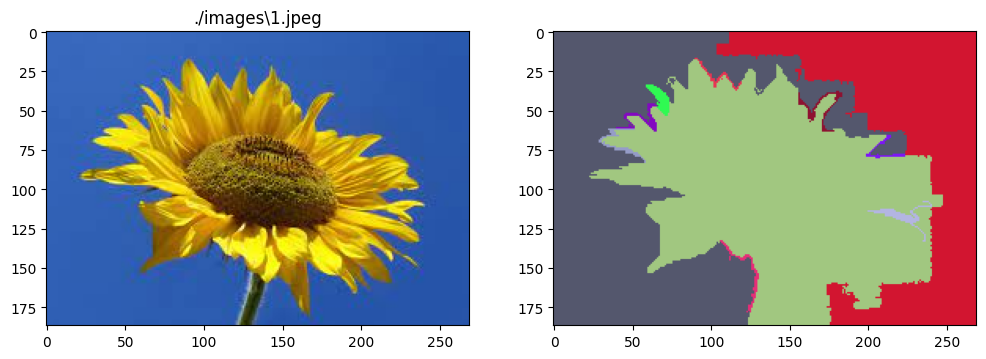

In [9]:
output_dir = './output'
os.makedirs(output_dir, exist_ok=True)

image = np.array(Image.open(image_files[0]))
segmented_image = segment(image, 0.2, 400, 50)
fig = plt.figure(figsize=(12, 12))
a = fig.add_subplot(1, 2, 1)
plt.imshow(image)
plt.title(image_files[0])
a = fig.add_subplot(1, 2, 2)
plt.imshow(segmented_image.astype(np.uint8))
plt.savefig('./output/' + str(0) + '.jpg')
plt.show()

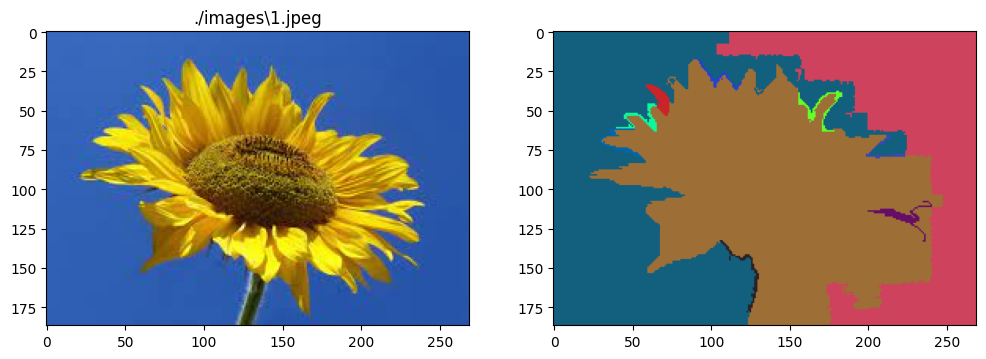

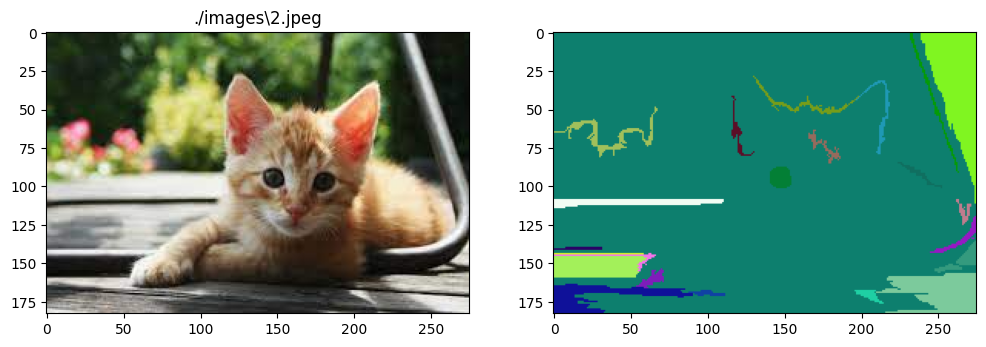

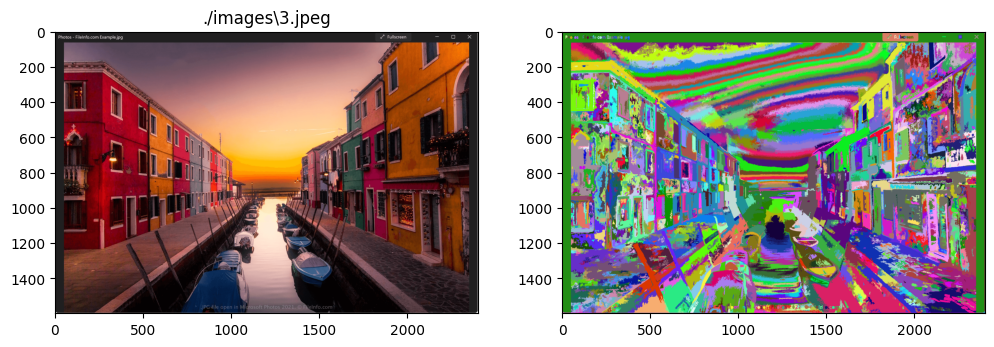

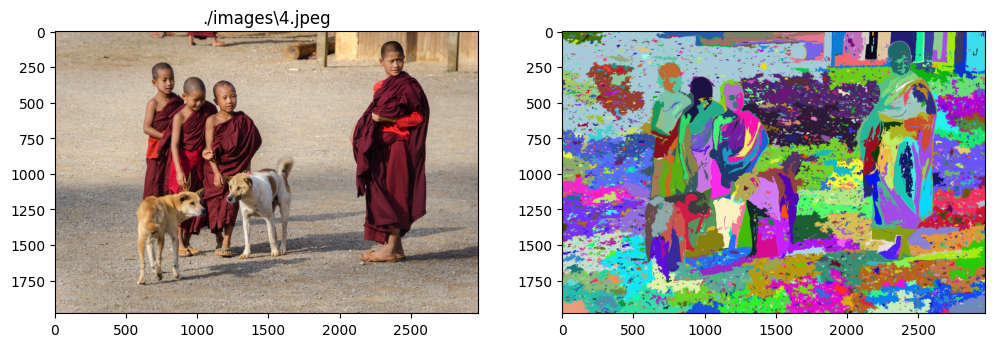

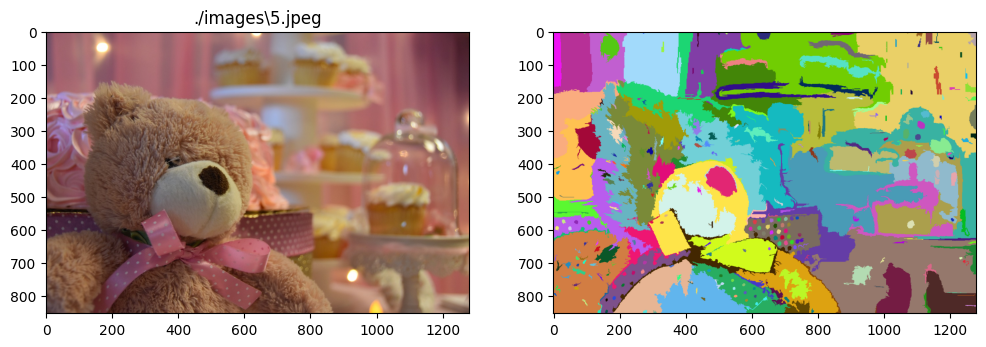

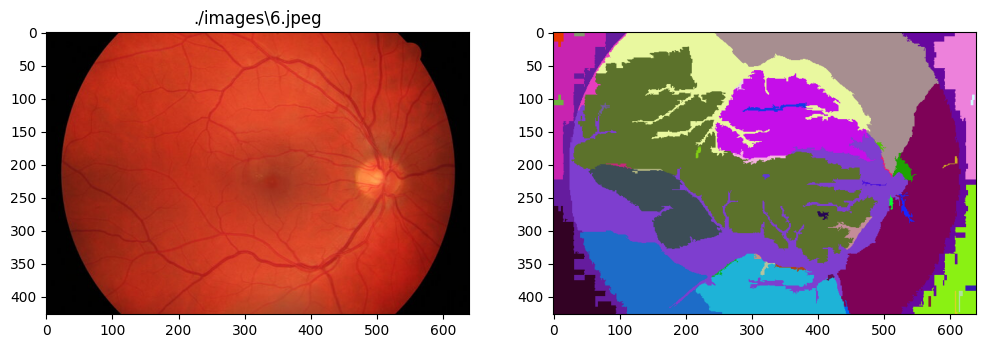

In [10]:
output_dir = './output'
os.makedirs(output_dir, exist_ok=True)      # Create a directory to save the segmented output images.

for i in range(len(image_files)):
    image = np.array(Image.open(image_files[i]))
    segmented_image = segment(image, 0.2, 400, 50)
    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(image_files[i])
    a = fig.add_subplot(1, 2, 2)
    plt.imshow(segmented_image.astype(np.uint8))
    plt.savefig('./output/' + str(i) + '.jpg')
    plt.show()